In [3]:
%config Completer.use_jedi = False

from utils import *
from parallel import to_run, findpos, find_relaxation

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import importlib
from multiprocessing import Pool
from tqdm.notebook import tqdm
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 72
plt.rcParams["figure.figsize"] = [12,8]

from ising_model import SimulateMH

In [2]:
pool = Pool(4)

In [3]:
scale = 100
times = 1000

# Ts = np.concatenate([
#     np.linspace(0,1.8,scale),
#     np.linspace(1.8,3.5,5*scale),
#     np.linspace(3.5,6,scale),
# ])
Ts1=np.linspace(0,4.5,scale+1)[1:]
Ts = [Ts1]*times

steps = np.ones_like(Ts1)*10**5
b=0.08
n=0.1
steps = np.exp(np.log(3*10**6)*(b/(b+Ts1-2.5))**n)
steps[Ts1<2.5] = 3*10**6
steps = steps.astype(int)

/home/ashot/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


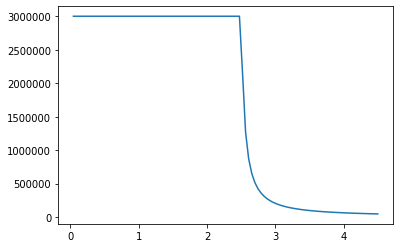

In [4]:
plt.plot(Ts1, steps)

In [ ]:
results = []
for Ts1 in tqdm(Ts):
    runs = len(Ts1)
    res = pool.starmap(find_relaxation, #T, N, steps, SEED
            zip(*(Ts1,
                  [32]*runs, # N
                  steps, # steps
                  np.random.randint(0,1000000, runs), # seed
                      )),
#             chunksize=1
        )
    results+= res

In [3]:
import pickle

In [4]:
with open("dumps/relaxations.pkl","rb") as f:
    results = pickle.load(f)

In [5]:
len(results)

84100

In [9]:
df = pd.DataFrame(results, columns=["T",  "RTM_const", "RTE_const", "RTM_rand", "RTE_rand"])

In [10]:
gb = df.groupby("T")

In [11]:
dfmoments = pd.concat([
gb.mean().add_suffix("_mean"),
gb.std().add_suffix("_std")], axis=1)
dfm = dfmoments[sorted(dfmoments.columns)]

In [18]:
sprs=2

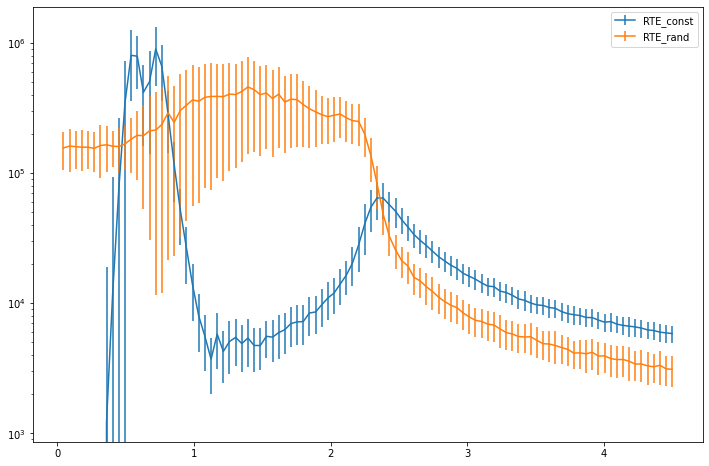

In [19]:
plt.errorbar(dfm.index, dfm.RTE_const_mean, yerr=dfm.RTE_const_std/sprs, label="RTE_const")
plt.errorbar(dfm.index, dfm.RTE_rand_mean, yerr=dfm.RTE_rand_std/sprs, label="RTE_rand")
plt.gca().set_yscale("log")
plt.legend()


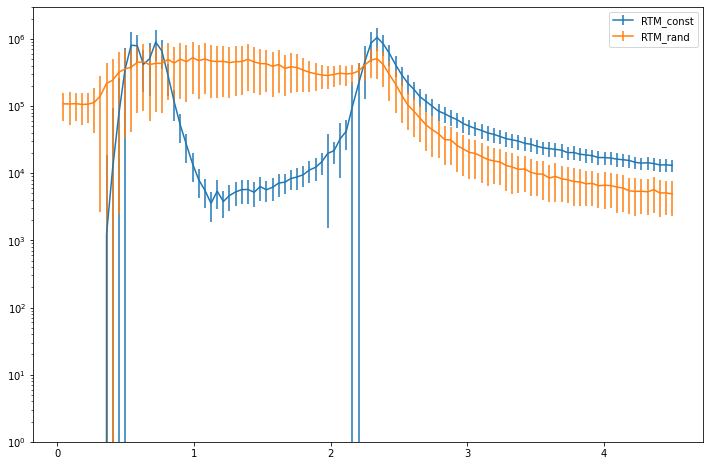

In [20]:
plt.errorbar(dfm.index, dfm.RTM_const_mean, yerr=dfm.RTM_const_std/sprs, label="RTM_const")
plt.errorbar(dfm.index, dfm.RTM_rand_mean, yerr=dfm.RTM_rand_std/sprs, label="RTM_rand")
plt.gca().set_yscale("log")
plt.ylim(1,3*10**6)
plt.legend()

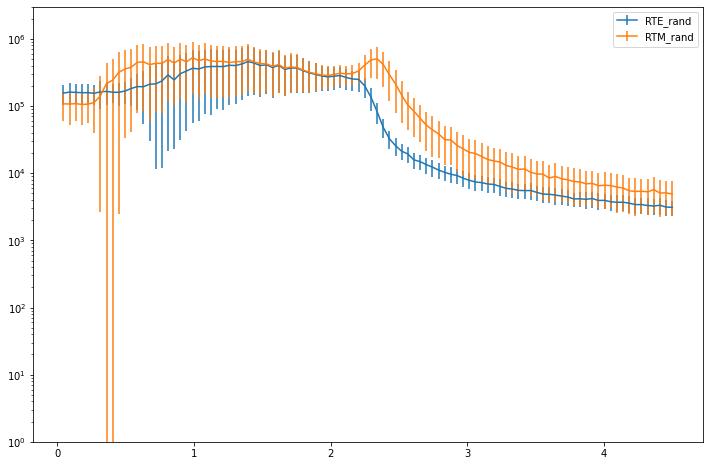

In [22]:
# plt.errorbar(dfm.index, dfm.RTE_const_mean, yerr=dfm.RTE_const_std/sprs, label="RTE_const")
plt.errorbar(dfm.index, dfm.RTE_rand_mean, yerr=dfm.RTE_rand_std/sprs, label="RTE_rand")
# plt.errorbar(dfm.index, dfm.RTM_const_mean, yerr=dfm.RTM_const_std/sprs, label="RTM_const")
plt.errorbar(dfm.index, dfm.RTM_rand_mean, yerr=dfm.RTM_rand_std/sprs, label="RTM_rand")
plt.gca().set_yscale("log")
plt.ylim(1,3*10**6)
plt.legend()

In [8]:
x = dfm.index.values
y = np.maximum(dfm.RTM_rand_mean, dfm.RTE_rand_mean).values

NameError: name 'dfm' is not defined

In [33]:
y[x>2].argmax()

7

In [34]:
x[x>2][7]

2.34

In [47]:
from scipy.optimize import curve_fit

In [114]:
def f(x,a,b,c):
    return a/(x-b)+c
    return a + b*x + c*x*x
popt, popt_cov = curve_fit(f,x[x>2.34], np.log(y[x>2.34]), maxfev = 80000, p0=(1, 1, 10))

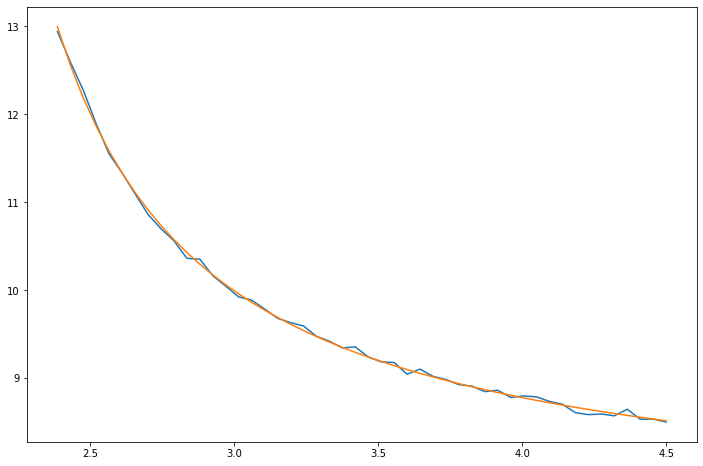

In [116]:
plt.plot(x[x>2.34], np.log(y[x>2.34]))
plt.plot(x[x>2.34], (f(x[x>2.34], *popt)))

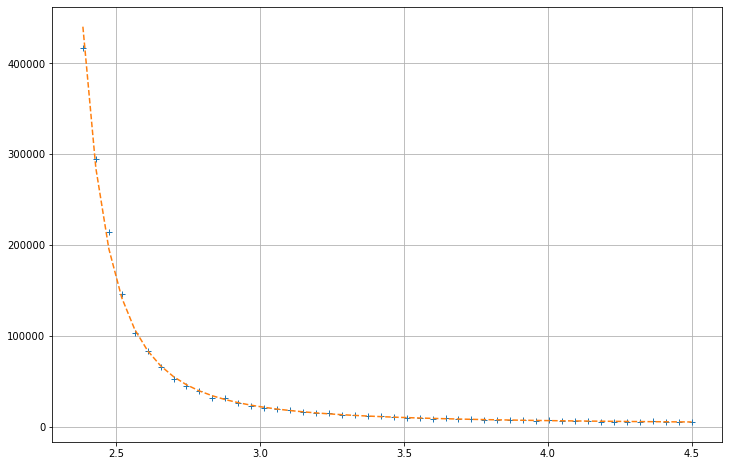

In [117]:
plt.plot(x[x>2.34],y[x>2.34], "+")
plt.plot(x[x>2.34],np.exp(f(x[x>2.34], *popt)), "--")

# plt.gca().set_yscale("log")

plt.grid()

In [ ]:
steps_needed_normalized

In [127]:
popt

array([2.99087349, 1.85163161, 7.38761709])

In [7]:
plt.plot(x,y)
# plt.plot(x[x>2.2],np.exp(f(x[x>2.2], *popt)), "--")
plt.plot(x,[relaxation_time_normalized(c)*32*32 for c in x], "--")
# plt.plot(x[(x<2.34)&(x>1)], (f(x[(x<2.34)&(x>1)], *popt)))
# plt.gca().set_yscale("log")
# plt.ylim(0,0.6e6)
plt.grid()

NameError: name 'x' is not defined

In [139]:
np.where(np.exp(f(np.linspace(2,4,10000), *popt))<5e5)
np.linspace(2,4,10000)[1866]

2.3732373237323734

In [134]:
f(x, *popt)

array([ 5.73211993e+00,  5.68983108e+00,  5.64532510e+00,  5.59842294e+00,
        5.54892572e+00,  5.49661195e+00,  5.44123418e+00,  5.38251510e+00,
        5.32014291e+00,  5.25376574e+00,  5.18298506e+00,  5.10734763e+00,
        5.02633582e+00,  4.93935570e+00,  4.84572252e+00,  4.74464258e+00,
        4.63519071e+00,  4.51628189e+00,  4.38663511e+00,  4.24472706e+00,
        4.08873200e+00,  3.91644279e+00,  3.72516579e+00,  3.51157901e+00,
        3.27153755e+00,  2.99980194e+00,  2.68965133e+00,  2.33232008e+00,
        1.91615614e+00,  1.42532633e+00,  8.37756224e-01,  1.21718549e-01,
       -7.70090636e-01, -1.91144876e+00, -3.42413911e+00, -5.52458229e+00,
       -8.63792940e+00, -1.37296572e+01, -2.35636792e+01, -5.05395650e+01,
       -4.43615221e+02,  8.53391089e+01,  4.32630055e+01,  3.06867596e+01,
        2.46391670e+01,  2.10840749e+01,  1.87438526e+01,  1.70866445e+01,
        1.58515135e+01,  1.48954253e+01,  1.41334148e+01,  1.35118330e+01,
        1.29951363e+01,  

<AxesSubplot:>

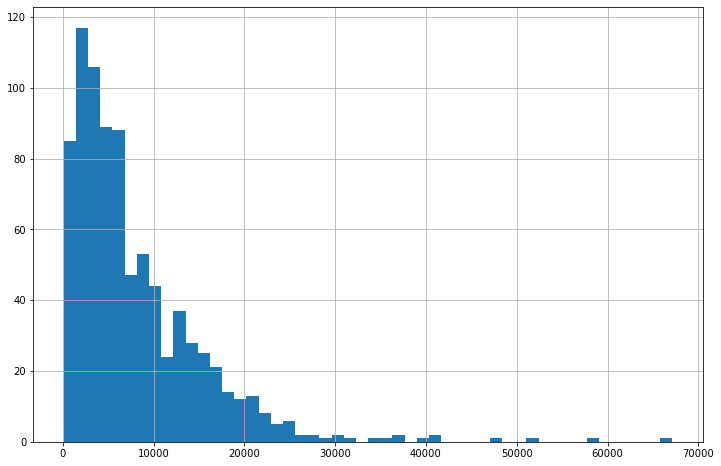

In [16]:
gb.get_group(1.035).RTM_const.hist(bins=50)

# Debug area

In [29]:
Mss_rand  = []
Mss_const = []
Ess_rand  = []
Ess_const = []
T = 2.35
steps = 1_000_000

for _ in tqdm(range(10)):
    SEED = np.random.randint(100000000)
    _,_,Ms, Es, engine = to_run(1, steps, T=T, N=32,M=32, freq=max(1,steps//10**5), 
                            SEED=SEED, return_engine=True, 
                            init="random")
    Mss_rand.append(Ms)
    Ess_rand.append(Es)
    
    SEED = np.random.randint(100000000)
    _,_,Ms, Es, engine = to_run(1, steps, T=T, N=32,M=32, freq=max(1,steps//10**5), 
                            SEED=SEED, return_engine=True, 
                            init="constant")
    Mss_const.append(Ms)
    Ess_const.append(Es)
    

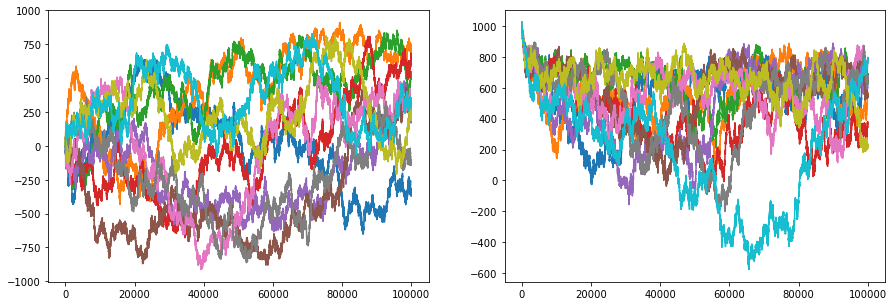

In [30]:
till=-1#1000
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(np.array(Mss_rand).T[:till]);
plt.subplot(122)
plt.plot(np.array(Mss_const).T[:till]);

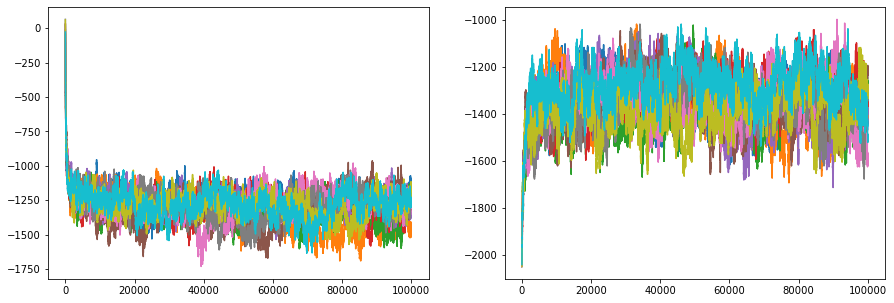

In [31]:
till=-1#1000
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(np.array(Ess_rand).T[:till]);
plt.subplot(122)
plt.plot(np.array(Ess_const).T[:till]);

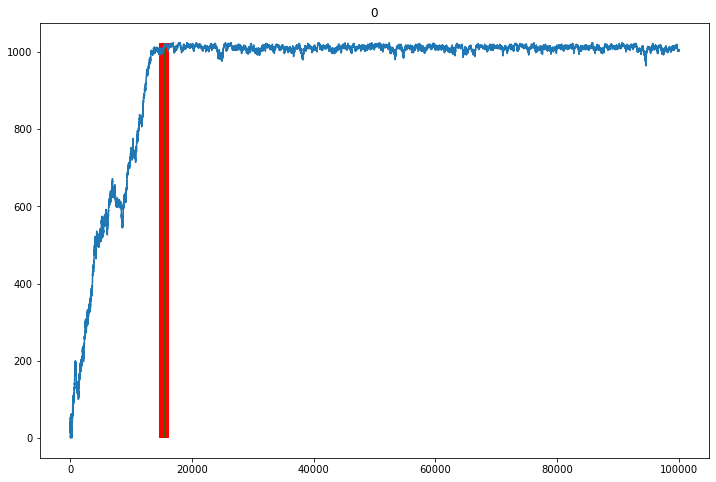

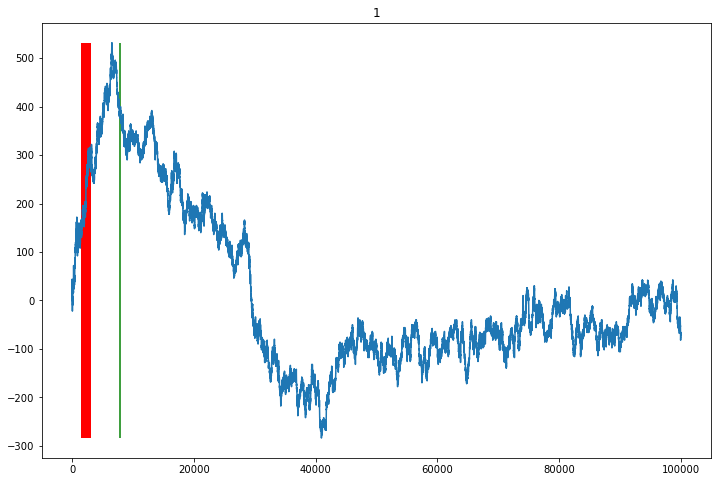

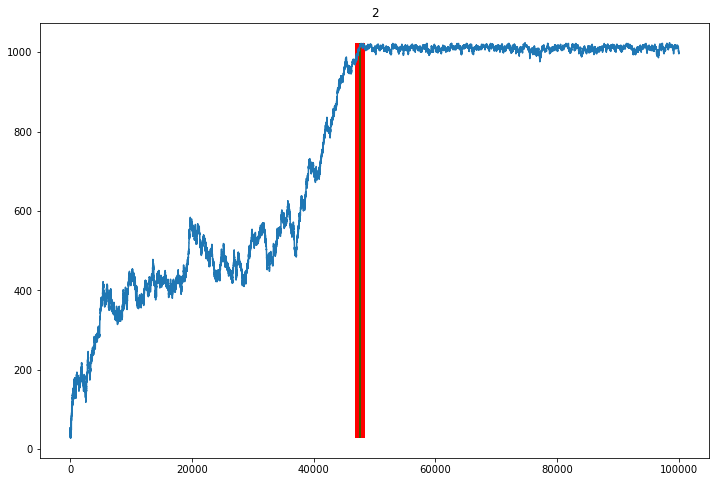

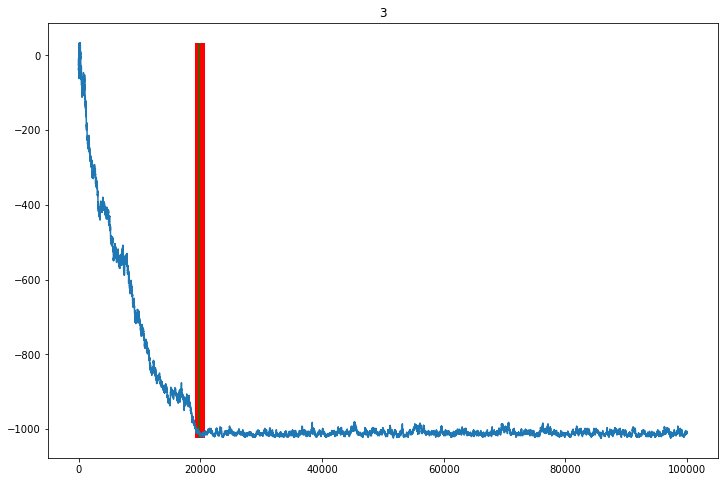

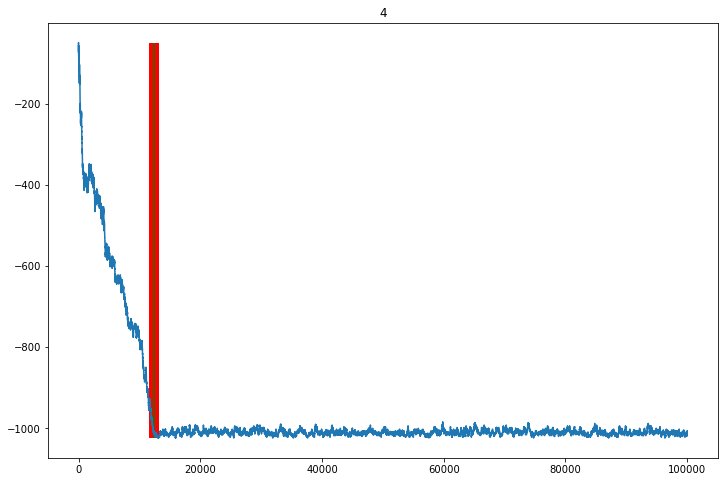

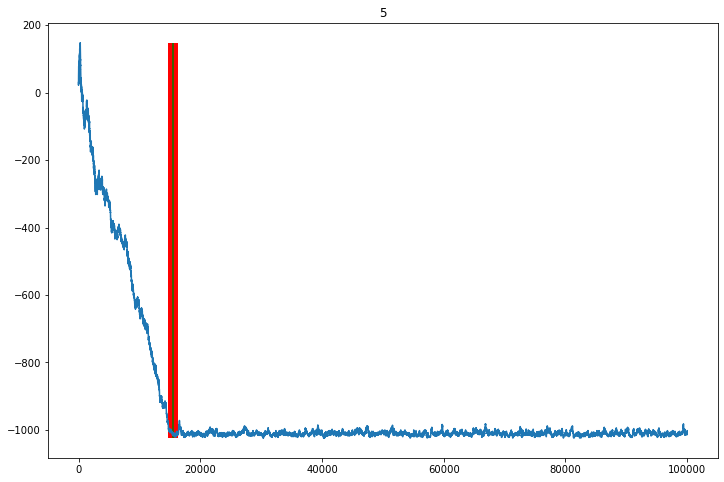

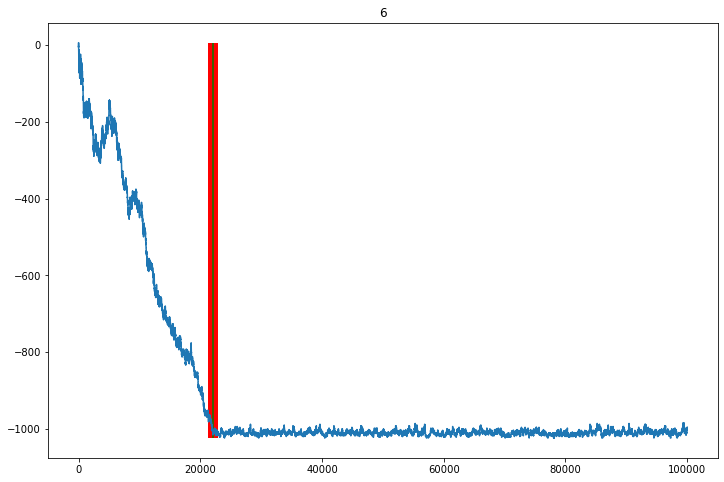

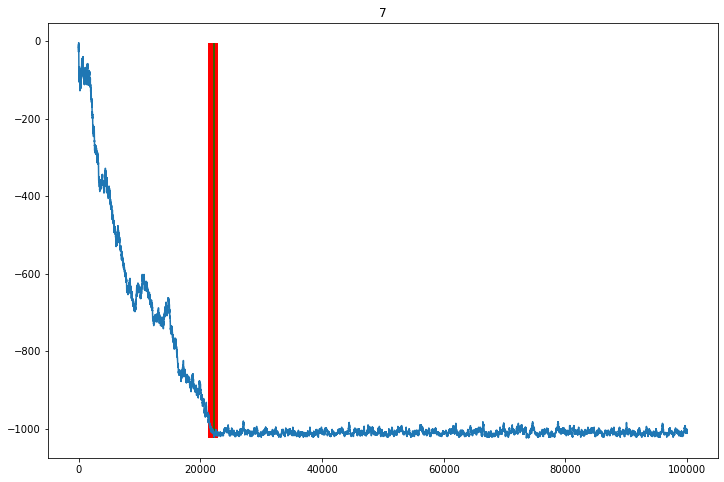

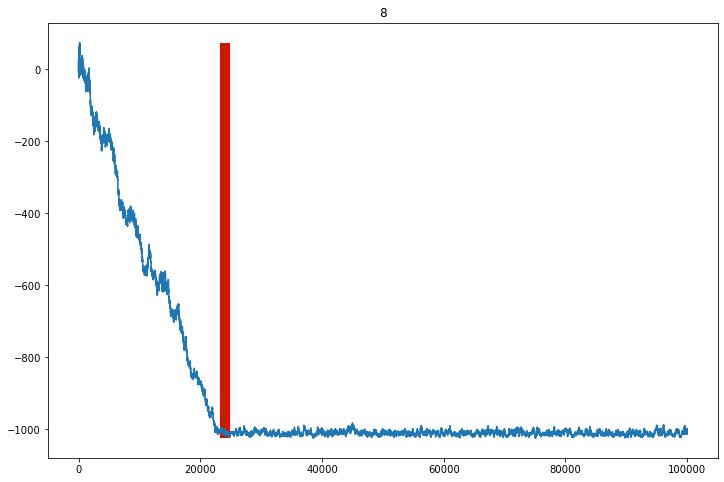

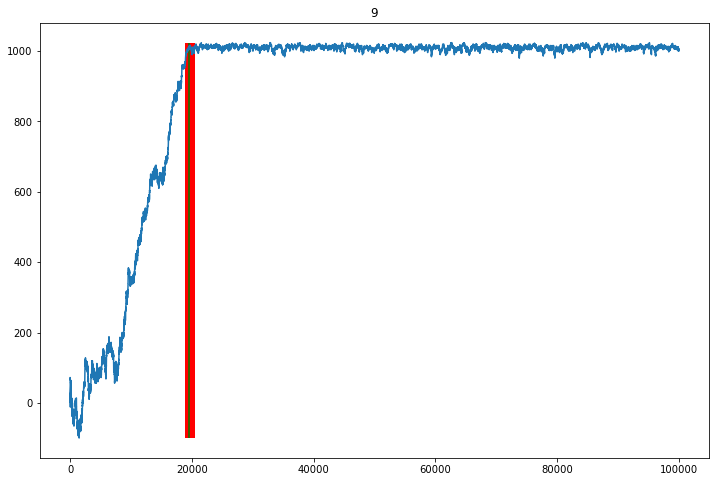

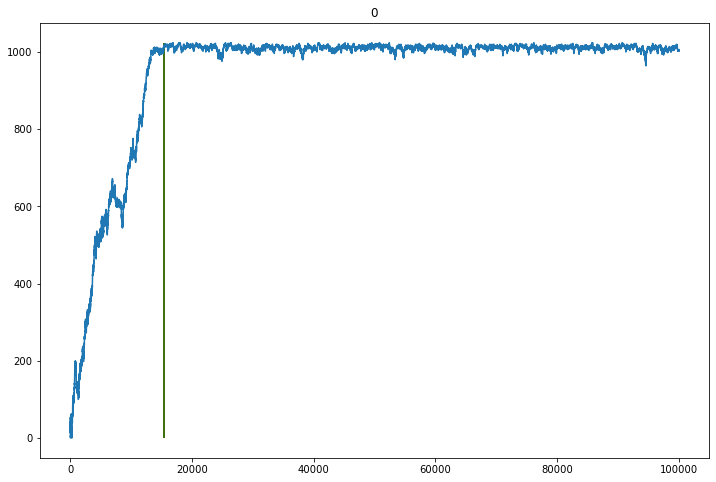

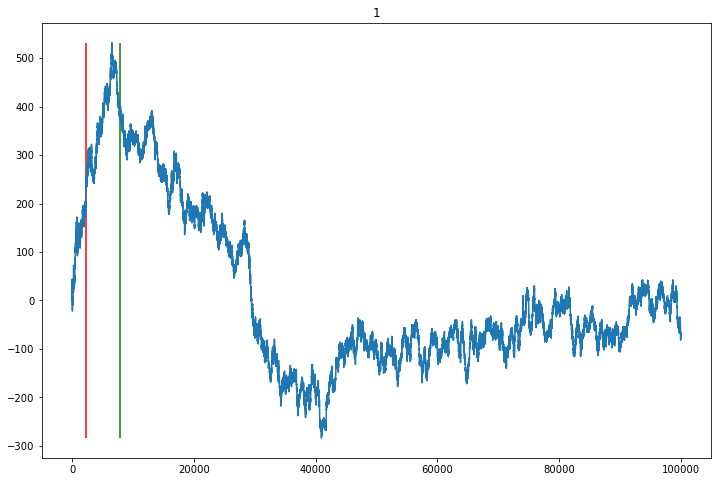

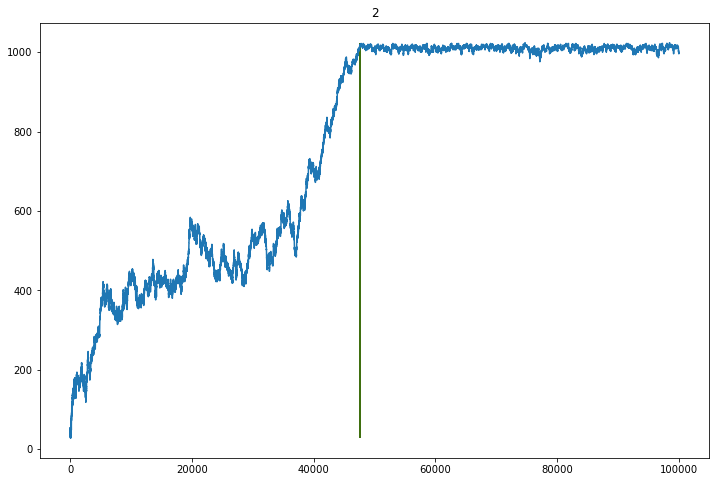

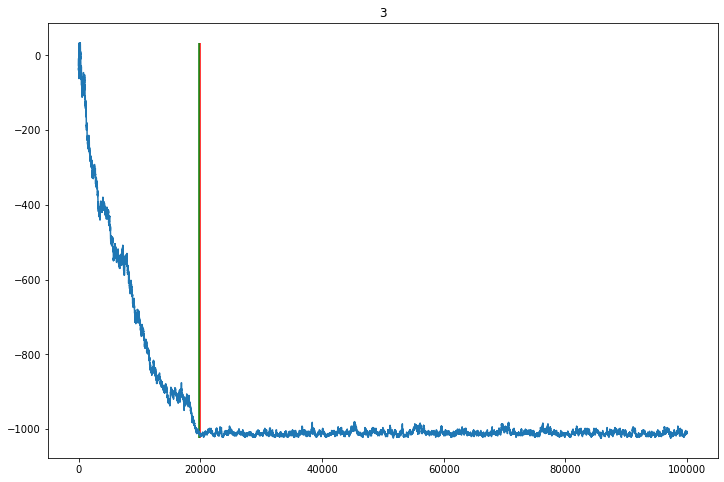

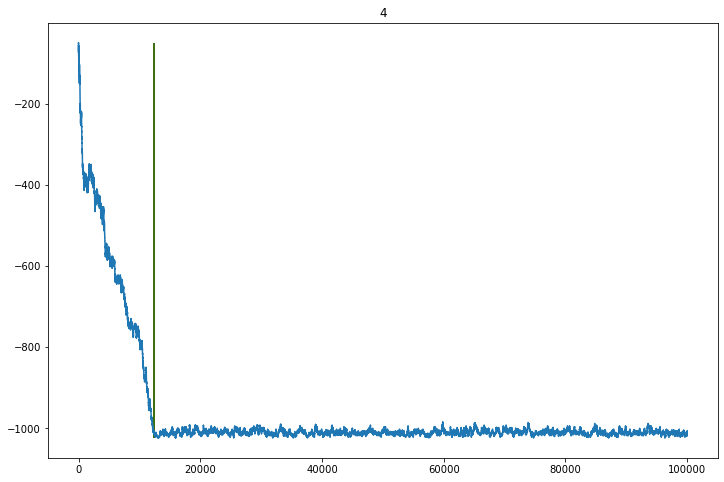

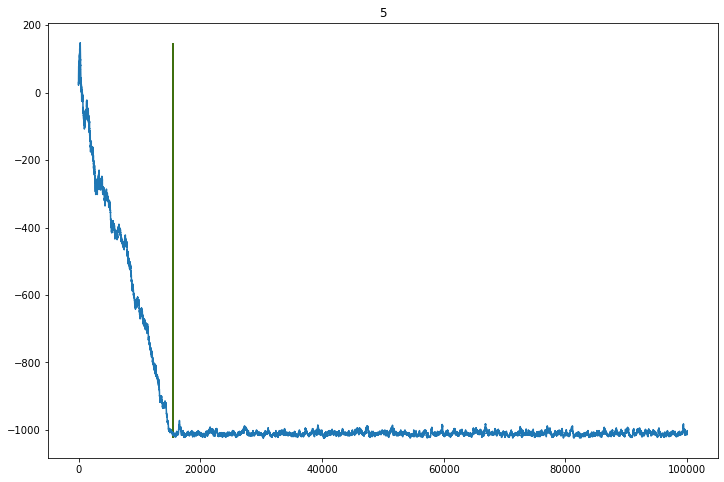

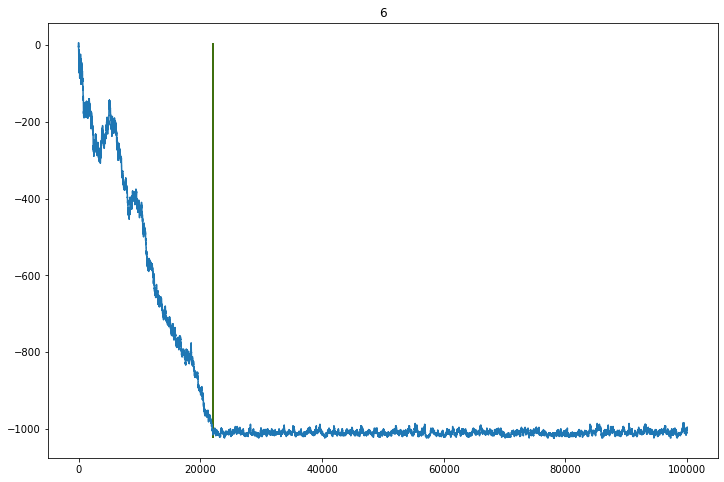

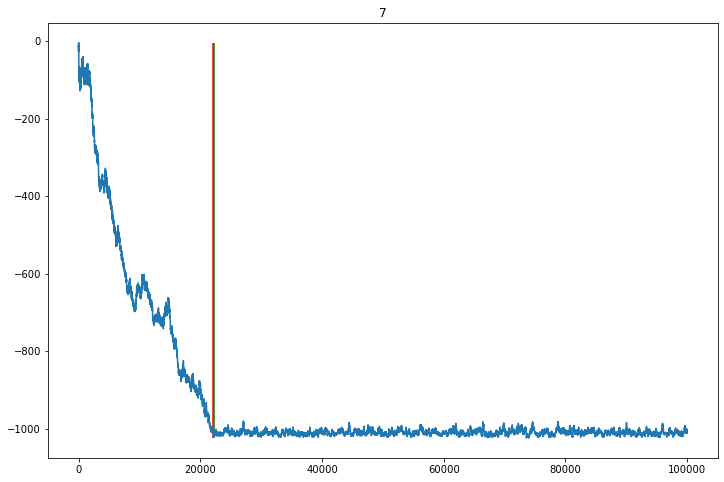

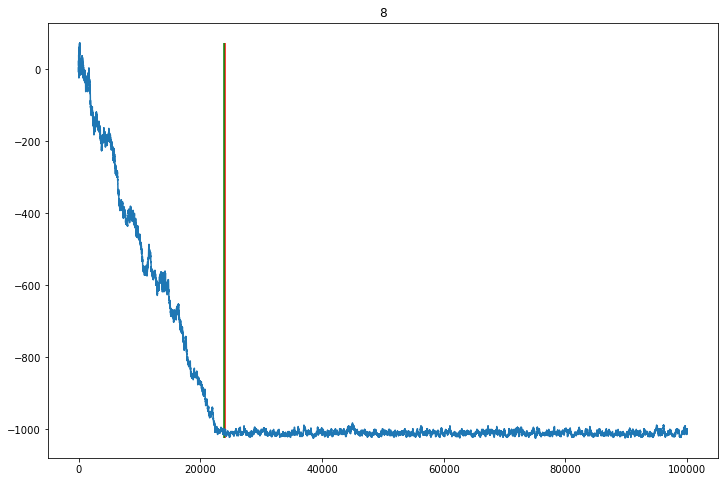

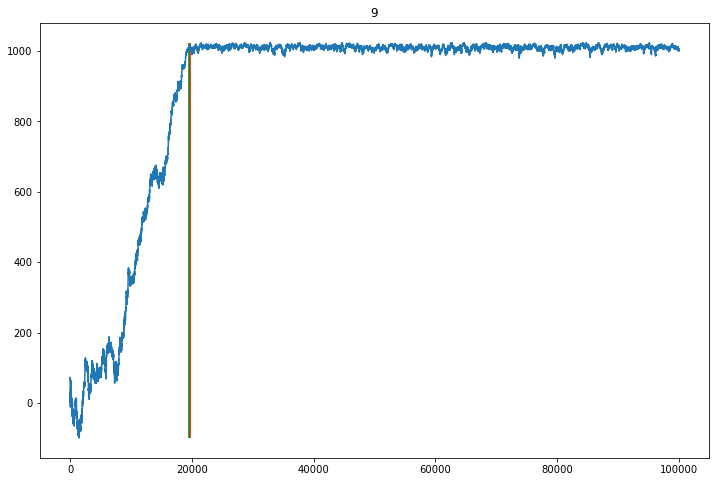

In [23]:
for i, (Ms, Es) in enumerate(zip(Mss_rand, Ess_rand)):
    plt.figure()
    plt.title(i)
    plt.plot(Ms)
    pos = findpos(Ms)
    plt.vlines(x=pos, ymax=Ms.max(), ymin=Ms.min(), color="r", lw=10)
    pos = findpos(Es)
    plt.vlines(x=pos, ymax=Ms.max(), ymin=Ms.min(), color="g")
    
    
for i, (Ms, Es) in enumerate(zip(Mss_rand, Ess_rand)):
    plt.figure()
    plt.title(i)
    plt.plot(Ms)
    pos = findpos(Ms)
    plt.vlines(x=pos, ymax=Ms.max(), ymin=Ms.min(), color="r")
    pos = findpos(Es)
    plt.vlines(x=pos, ymax=Ms.max(), ymin=Ms.min(), color="g")

In [103]:
Ms = Mss_rand[4]

In [54]:
Ms = Mss_const[4]

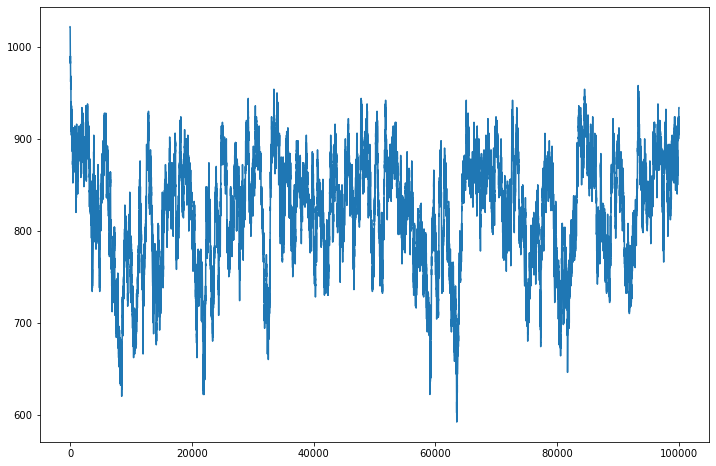

In [59]:
plt.plot(Ms)

In [64]:
np.mean(Ms)

822.91476

In [96]:
findpos(Ms)

(array([ 5531,  5532,  5533, ..., 88733, 88734, 88770], dtype=int64),)
(array([ 5532,  5533,  5534, ..., 88731, 88732, 88733], dtype=int64),)
(array([ 5532,  5533,  5534, ..., 88731, 88732, 88733], dtype=int64),)


5532

In [50]:
pos = [0]
for _ in range(400):
    pos.append(findpos(Ms, start=pos[-1]))
    if pos[-1]==pos[-2]:
        break

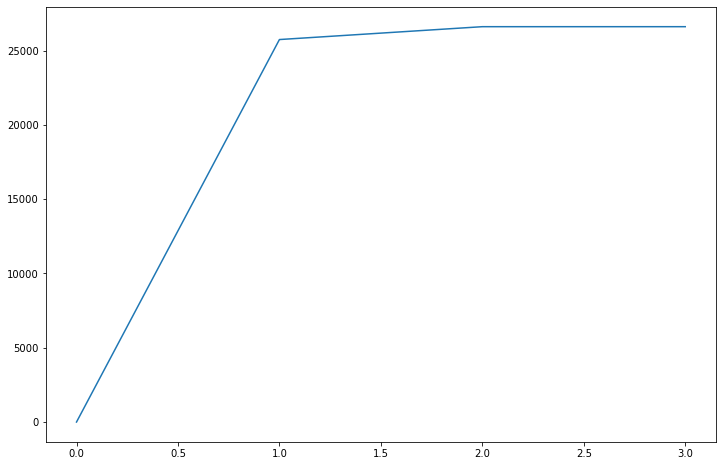

In [51]:
plt.plot(pos)

In [38]:
findpos(Ms, 4524)

4901

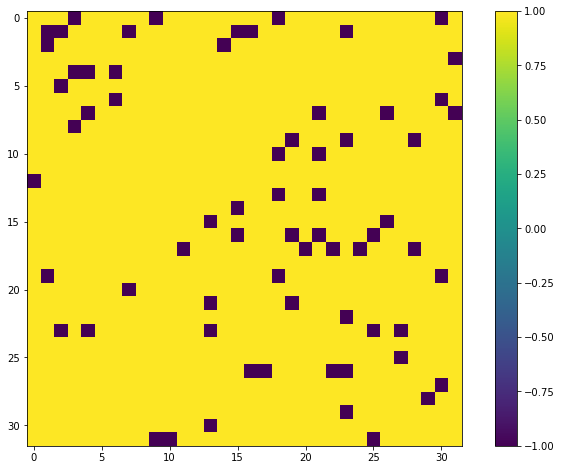

In [18]:
plt.imshow(engine.get_state())
plt.colorbar()